In [ ]:
import numpy
import pandas
import seaborn
from matplotlib import pyplot
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt

In [41]:
cdc = fetch_ucirepo(id=891)
X = cdc.data.features
y = cdc.data.targets

df = pandas.concat([X, y], axis=1)
df.rename(columns={'Diabetes_binary': 'y'}, inplace=True)

In [42]:
feature_cols = ['Smoker', 'BMI', 'Fruits', 'Veggies', 'PhysActivity',
    'HighBP', 'HighChol', 'HeartDiseaseorAttack', 'Stroke', 'Age'
]
print("Variaveis explicativas :", feature_cols)


Variaveis explicativas : ['Smoker', 'BMI', 'Fruits', 'Veggies', 'PhysActivity', 'HighBP', 'HighChol', 'HeartDiseaseorAttack', 'Stroke', 'Age']


In [43]:
display(df[feature_cols + ['y']].describe())
print("Distribuição da variavel-alvo (%):")
print(100 * df.y.value_counts(normalize=True))


,Smoker,BMI,Fruits,Veggies,PhysActivity,HighBP,HighChol,HeartDiseaseorAttack,Stroke,Age,y
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.443169,28.382364,0.634256,0.811420,0.756544,0.429001,0.424121,0.094186,0.040571,8.032119,0.139333
std,0.496761,6.608694,0.481639,0.391175,0.429169,0.494934,0.494210,0.292087,0.197294,3.054220,0.346294
min,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,24.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000
50%,0.000000,27.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000
75%,1.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,10.000000,0.000000
max,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000,1.000000


Distribuição da variavel-alvo (%):
y
0    86.066698
1    13.933302
Name: proportion, dtype: float64


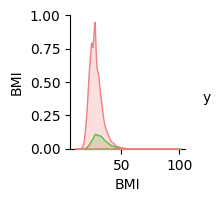

In [44]:
selected_for_plot = ['BMI']
_ = seaborn.pairplot(df[selected_for_plot + ['y']],hue='y',palette={0: 'lightcoral', 1: 'limegreen'},height=2.0)


In [45]:
centros = df.groupby('y')[feature_cols].median().T
centros['diff'] = abs(centros[1] - centros[0])
centros = centros.sort_values('diff', ascending=False)
display(centros)

x_cols_sorted = centros.index.tolist()

y,0,1,diff
BMI,27.0,31.0,4.0
Age,8.0,10.0,2.0
Smoker,0.0,1.0,1.0
HighBP,0.0,1.0,1.0
HighChol,0.0,1.0,1.0
Fruits,1.0,1.0,0.0
PhysActivity,1.0,1.0,0.0
Veggies,1.0,1.0,0.0
HeartDiseaseorAttack,0.0,0.0,0.0
Stroke,0.0,0.0,0.0


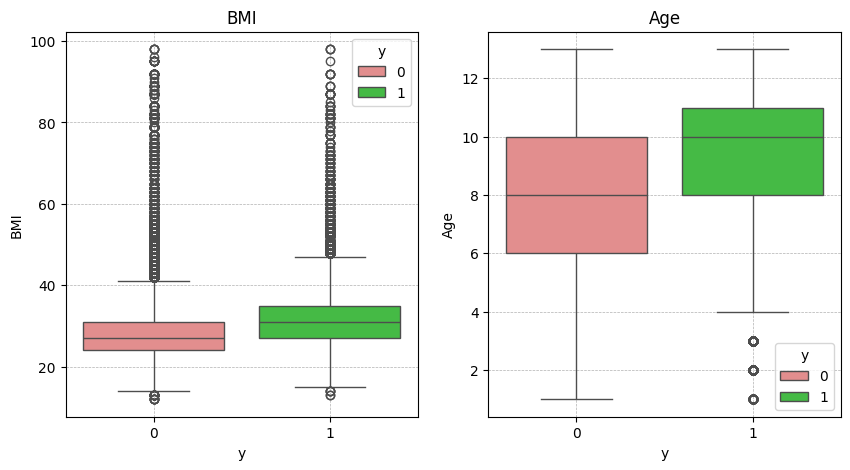

In [46]:
variaveis_numericas = []

for col in x_cols_sorted:
    if df[col].nunique() > 5:
        variaveis_numericas.append(col)

num_graficos = len(variaveis_numericas)

largura_figura = 5 * num_graficos
altura_figura = 5

fig, axs = pyplot.subplots(nrows=1,ncols=num_graficos,figsize=(largura_figura, altura_figura))
if len(variaveis_numericas) == 1:
    axs = [axs]

for i, ax in enumerate(axs):
    seaborn.boxplot(data=df, x='y', y=variaveis_numericas[i], ax=ax,hue='y', dodge=False, palette=['lightcoral', 'limegreen'])
    ax.set_title(variaveis_numericas[i])
    ax.grid(True, linestyle='--', linewidth=0.5)


In [47]:
select_by_center_stat = True
if select_by_center_stat:
    model_cols = x_cols_sorted[:2]
else:
    model_cols = feature_cols

print("Variáveis utilizadas no modelo:", model_cols)


Variáveis utilizadas no modelo: ['BMI', 'Age']


In [48]:
X_model = df[feature_cols].to_numpy()
y_model = df['y'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X_model, y_model, stratify=y_model, test_size=0.2, random_state=42)



In [49]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [50]:
k = 7
knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', weights='uniform')
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia inicial com k={k}: {100 * accuracy:.2f}%')


Acurácia inicial com k=7: 85.06%


In [51]:
best_k = 17

final_knn = KNeighborsClassifier(n_neighbors=best_k,metric='minkowski', weights='uniform')
final_knn.fit(X_train_scaled, y_train)
y_pred_final = final_knn.predict(X_test_scaled)

accuracy_final = accuracy_score(y_test, y_pred_final)
print(f'Acurácia final com k={best_k}: {100 * accuracy_final:.2f}%')


Acurácia final com k=17: 85.86%


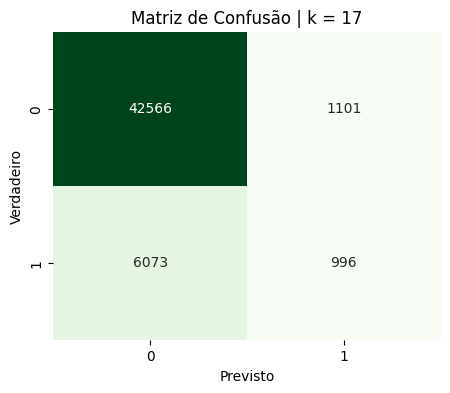

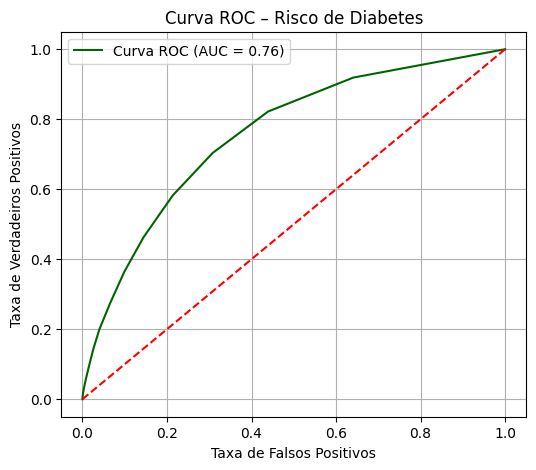

In [52]:
conf_matrix = confusion_matrix(y_test, y_pred_final)
pyplot.figure(figsize=(5, 4))
_ = seaborn.heatmap(conf_matrix, annot=True, cmap='Greens', cbar=False, fmt='d')
pyplot.title(f'Matriz de Confusão | k = {best_k}')
pyplot.xlabel('Previsto')
pyplot.ylabel('Verdadeiro')

y_proba = final_knn.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thr = roc_curve(y_test, y_proba)
roc_score = roc_auc_score(y_test, y_proba)

pyplot.figure(figsize=(6, 5))
pyplot.plot(fpr, tpr, color='darkgreen', label=f'Curva ROC (AUC = {roc_score:.2f})')
pyplot.plot([0, 1], [0, 1], 'r--')
pyplot.xlabel('Taxa de Falsos Positivos')
pyplot.ylabel('Taxa de Verdadeiros Positivos')
pyplot.title('Curva ROC – Risco de Diabetes')
pyplot.grid(True)
pyplot.legend()


In [53]:

knn_cv = KNeighborsClassifier(n_neighbors=best_k, metric='minkowski', weights='uniform')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(knn_cv, X_train_scaled, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

acuracias_formatadas = []
for score in cv_scores:
    acuracia_formatada = f"{score * 100:.2f}%"
    acuracias_formatadas.append(acuracia_formatada)

print("Acurácia por dobra:")
for i, acuracia in enumerate(acuracias_formatadas, start=1):
    print(f"  Dobra {i}: {acuracia}")

media_acuracia = cv_scores.mean() * 100
print(f"\nAcurácia média obtida durante a validação cruzada: {media_acuracia:.2f}%")

desvio_padrao = cv_scores.std() * 100
print(f"Desvio padrão entre as dobras: {desvio_padrao:.2f}%")


Acurácia por dobra:
  Dobra 1: 85.83%
  Dobra 2: 85.99%
  Dobra 3: 85.97%
  Dobra 4: 86.12%
  Dobra 5: 85.86%

Acurácia média obtida durante a validação cruzada: 85.95%
Desvio padrão entre as dobras: 0.10%


Melhor valor de K encontrado: 30 com acurácia média de 86.18%


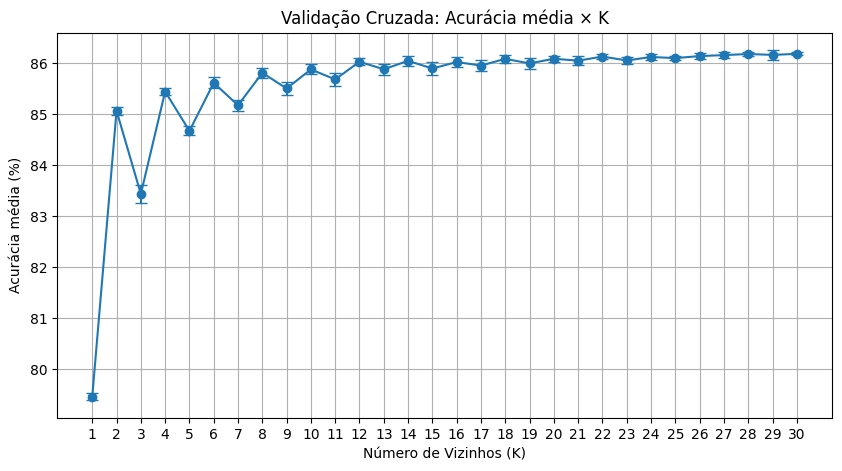

In [54]:
k_range = range(1, 31)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

mean_scores = []
std_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', weights='uniform')
    scores = cross_val_score(knn, X_train_scaled, y_train,
                             cv=cv, scoring='accuracy', n_jobs=-1)
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())

melhor_k = k_range[numpy.argmax(mean_scores)]
melhor_score = max(mean_scores)
print(f"Melhor valor de K encontrado: {melhor_k} com acurácia média de {melhor_score*100:.2f}%")

plt.figure(figsize=(10, 5))
plt.errorbar(k_range,
             [m*100 for m in mean_scores],
             yerr=[s*100 for s in std_scores],
             fmt='-o', capsize=4)
plt.title('Validação Cruzada: Acurácia média × K')
plt.xlabel('Número de Vizinhos (K)')
plt.ylabel('Acurácia média (%)')
plt.grid(True)
plt.xticks(k_range)
plt.show()

In [55]:
y_pred_final = final_knn.predict(X_test_scaled)
y_proba_final = final_knn.predict_proba(X_test_scaled)[:, 1]
precisao = precision_score(y_test, y_pred_final)
revocacao = recall_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)
auc = roc_auc_score(y_test, y_proba_final)

print(f"Precisão: {precisao:.4f}")
print(f"Recall: {revocacao:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC : {auc:.4f}")

Precisão: 0.4750
Recall: 0.1409
F1-score: 0.2173
AUC : 0.7570
